Description of business problem

Description of data and columns

What precision, recall etc. mean in context of the business problem

What results should be expected

**Accuracy**: out of all the predictions our model made, what percentage correctly predicted whether a patient will not be readmitted, or will be readmitted within 30 days or outside of 30 days.

**Precision**: When the model predicted someone would be readmitted, how many times was the patient actually readmitted.

**Recall**: Of all the patients that were actually readmitted, what percentage of them did our model correctly predict the readmission.

**F1 Score**: the harmonic mean of precision and recall, so takes into account both precision and recall of the model.

It is most important to predict if someone will be readmitted--therefore, better to have more false positives rather than false negatives. Readmissions are extremely costly to hospitals and lead to worse patient outcomes, so it is better to proactively try to prevent a readmission for someone that may not actually be readmitted rather than not proactively prevent a readmission. Therefore, recall is slightly more important than precision.

# Obtain

In [1]:
# import necessary libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# load raw dataset

df = pd.read_csv('data/diabetic_data.csv')

In [3]:
# inspect first 5 rows

df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


# Scrub

First, we are going to inspect the dataset from a high-level and scrub the data for missing values and incorrect datatypes. Then we will prepare each column to be fed into the model, including preparing the categorical variables.

In [4]:
df.shape

(101766, 50)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

We have 101,766 rows and 50 columns in our dataset.


It appears there are no missing values in the dataset, however, we already noticed some question marks in the data. We will need to deal with any ? as if they are missing values.

Now let's explore the proportions of values for the categorical variables and the distribution of the continuous variables.

## Explore Distributions of Each Variable

In [6]:
categoricals = []

for col in df.columns:
    if df[col].dtype == 'O':
        categoricals.append(col)

categoricals

['race',
 'gender',
 'age',
 'weight',
 'payer_code',
 'medical_specialty',
 'diag_1',
 'diag_2',
 'diag_3',
 'max_glu_serum',
 'A1Cresult',
 'metformin',
 'repaglinide',
 'nateglinide',
 'chlorpropamide',
 'glimepiride',
 'acetohexamide',
 'glipizide',
 'glyburide',
 'tolbutamide',
 'pioglitazone',
 'rosiglitazone',
 'acarbose',
 'miglitol',
 'troglitazone',
 'tolazamide',
 'examide',
 'citoglipton',
 'insulin',
 'glyburide-metformin',
 'glipizide-metformin',
 'glimepiride-pioglitazone',
 'metformin-rosiglitazone',
 'metformin-pioglitazone',
 'change',
 'diabetesMed',
 'readmitted']

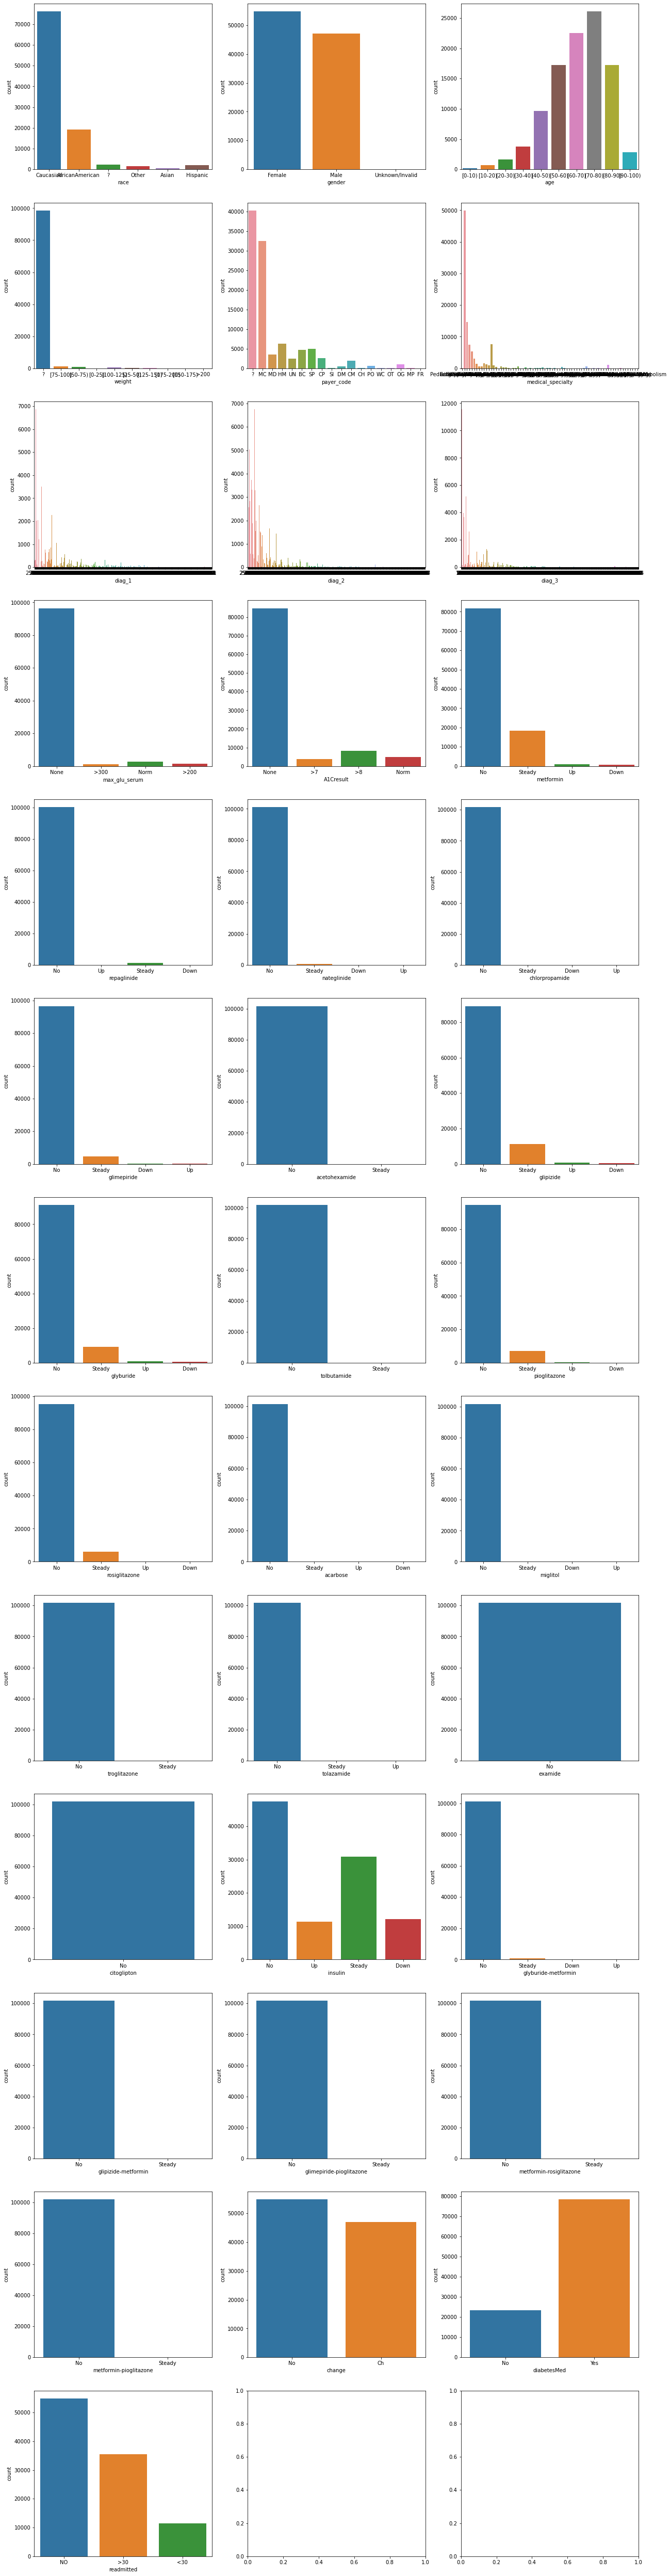

In [7]:
num_plots = len(categoricals)
total_cols = 3
total_rows = num_plots//total_cols +1

fig, axes = plt.subplots(nrows=total_rows, ncols=total_cols,
                        figsize=(7*total_cols, 7*total_rows))

for i, var in enumerate(categoricals):
    row = i//total_cols
    pos = i % total_cols
    plot = sns.countplot(x=var, data=df, ax=axes[row][pos])

At a glance, there are clearly some categorical values with very few differences among the dataset, especially for the drug columns. Some even have all the same values for every row, which won't be helpful to include in our model.

Our dependent variable in this analysis is in the 'readmitted' column--our model is trying to predict whether or not a patient will be readmitted. Although we have data for whether or not a patient is admitted within 30 days or outside of 30 days, this distinguishment isn't all that helpful for our analysis, so we will later group both types of readmissions together.

In [8]:
continuous = []
for col in df.columns:
    if col not in categoricals:
        continuous.append(col)

continuous

['encounter_id',
 'patient_nbr',
 'admission_type_id',
 'discharge_disposition_id',
 'admission_source_id',
 'time_in_hospital',
 'num_lab_procedures',
 'num_procedures',
 'num_medications',
 'number_outpatient',
 'number_emergency',
 'number_inpatient',
 'number_diagnoses']

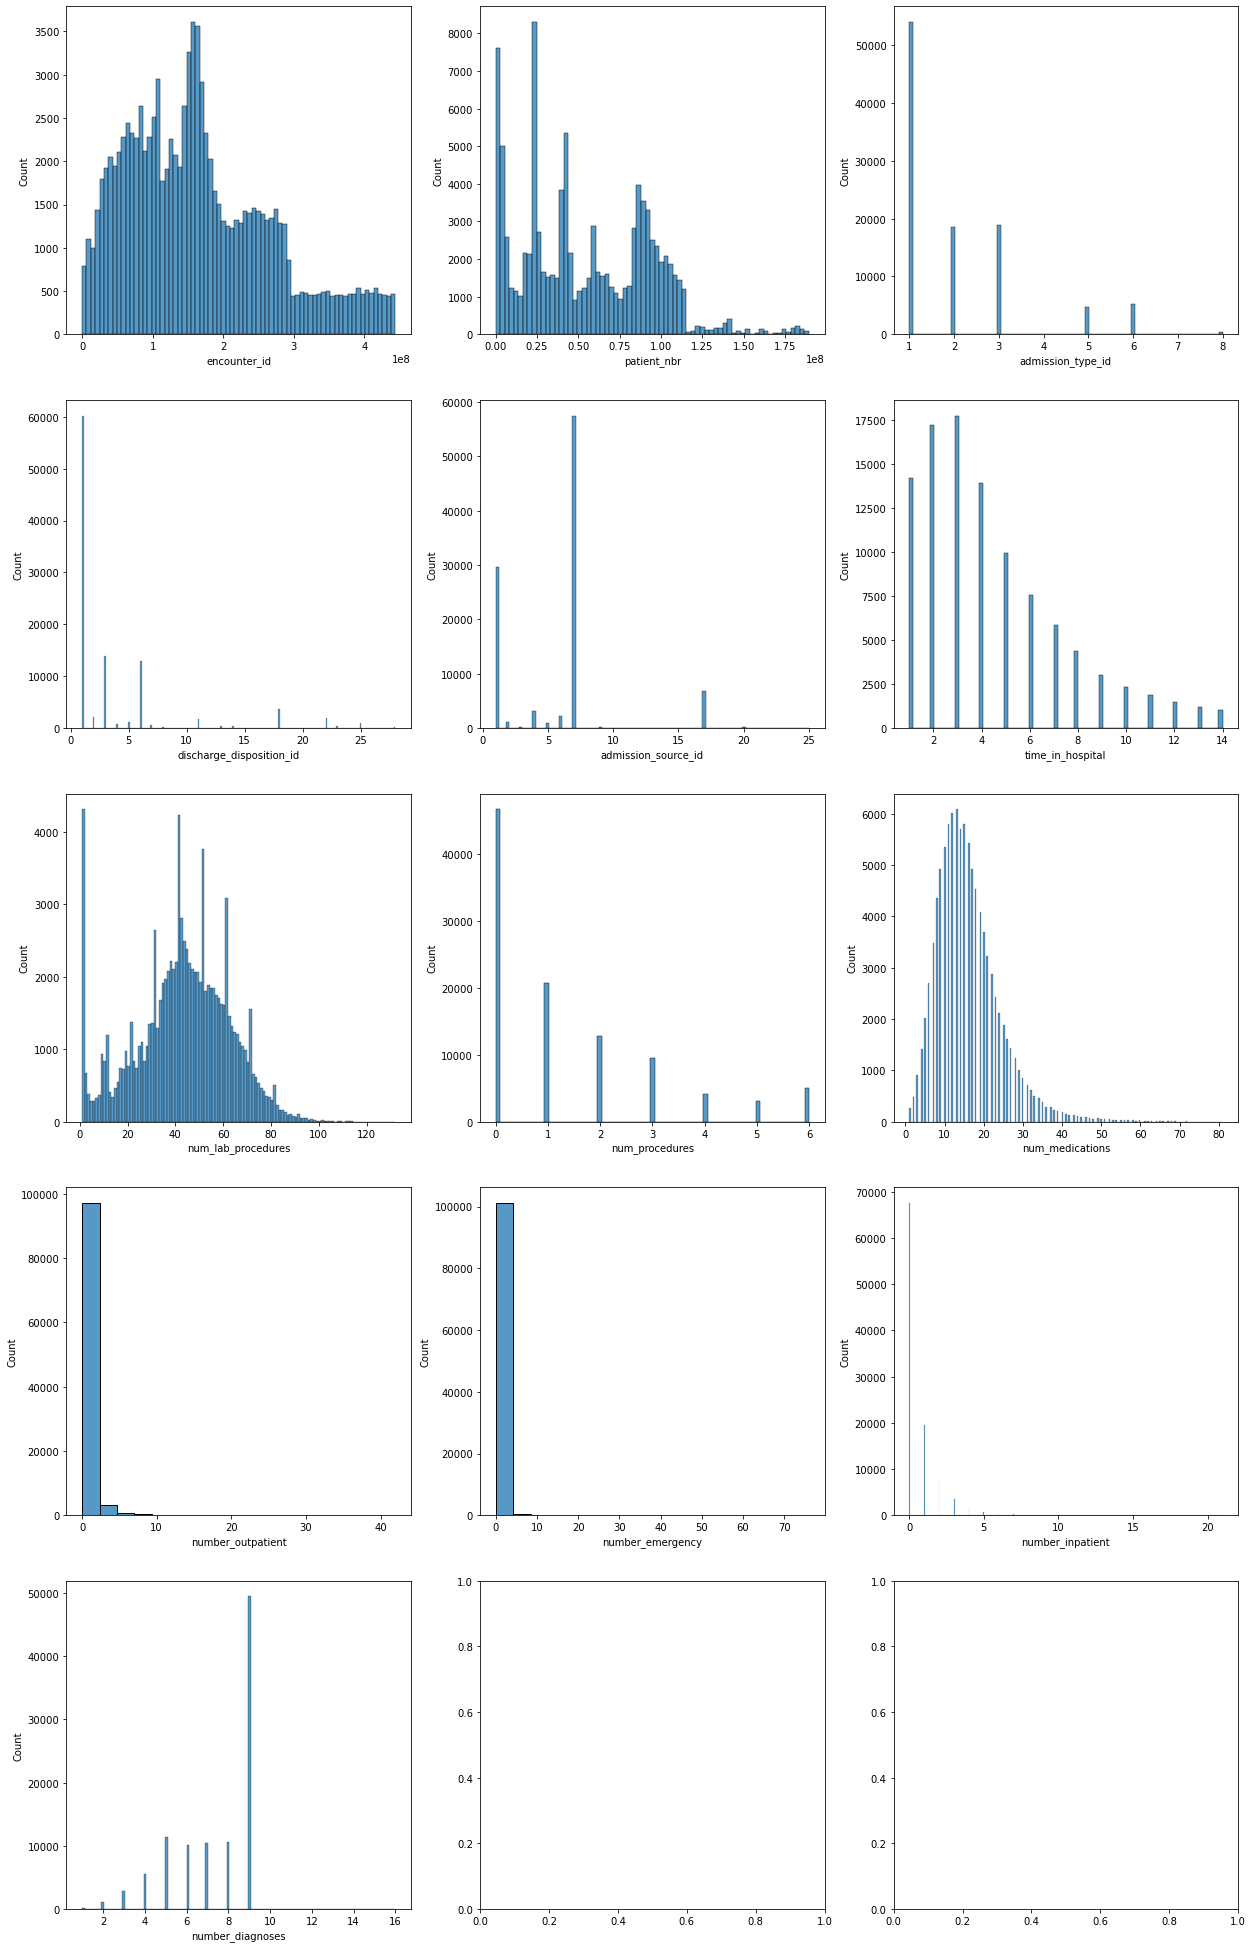

In [9]:
num_plots = len(continuous)
total_cols = 3
total_rows = num_plots//total_cols +1

fig, axes = plt.subplots(nrows=total_rows, ncols=total_cols,
                        figsize=(7*total_cols, 7*total_rows))

for i, var in enumerate(continuous):
    row = i//total_cols
    pos = i % total_cols
    plot = sns.histplot(x=var, data=df, ax=axes[row][pos])

It looks like there may be some potential outliers in our continuous variables, such as number_outpatient, number_emergency and number_inpatient. We will explore these variables further.

## Explore Top Values for Each Variable

In [10]:
# check the top values of each column

for col in df.columns:
    print(df[col].value_counts(normalize=True)[:10])
    print('--------------------------------------')

96210942     0.00001
89943846     0.00001
384306986    0.00001
94650156     0.00001
83156784     0.00001
2674482      0.00001
281345844    0.00001
193616274    0.00001
355508024    0.00001
165973818    0.00001
Name: encounter_id, dtype: float64
--------------------------------------
88785891    0.000393
43140906    0.000275
23199021    0.000226
1660293     0.000226
88227540    0.000226
23643405    0.000216
84428613    0.000216
92709351    0.000206
23398488    0.000197
90609804    0.000197
Name: patient_nbr, dtype: float64
--------------------------------------
Caucasian          0.747784
AfricanAmerican    0.188766
?                  0.022336
Hispanic           0.020017
Other              0.014799
Asian              0.006299
Name: race, dtype: float64
--------------------------------------
Female             0.537586
Male               0.462384
Unknown/Invalid    0.000029
Name: gender, dtype: float64
--------------------------------------
[70-80)     0.256156
[60-70)     0.220928
[50-6

The first thing we noticed in our top 10 value counts is that 97% of the values for weight are question marks. This won't be very useful to us, so let's drop the weight column. 39% of the values for payer code are question marks and 49% are question marks for medical_speciality, so let's also drop these columns.

## Handle Missing Values

In [11]:
# convert all "?" to NAN so to easily find missing values

df = df.replace("?", np.nan)
df.isna().sum()

encounter_id                    0
patient_nbr                     0
race                         2273
gender                          0
age                             0
weight                      98569
admission_type_id               0
discharge_disposition_id        0
admission_source_id             0
time_in_hospital                0
payer_code                  40256
medical_specialty           49949
num_lab_procedures              0
num_procedures                  0
num_medications                 0
number_outpatient               0
number_emergency                0
number_inpatient                0
diag_1                         21
diag_2                        358
diag_3                       1423
number_diagnoses                0
max_glu_serum                   0
A1Cresult                       0
metformin                       0
repaglinide                     0
nateglinide                     0
chlorpropamide                  0
glimepiride                     0
acetohexamide 

In [12]:
# drop columns with too many missing values
df.drop(columns=['weight', 'payer_code','medical_specialty'], inplace=True)
df.head()

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),6,25,1,1,41,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),1,1,7,3,59,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),1,1,7,2,11,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),1,1,7,2,44,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),1,1,7,1,51,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


Next, let's deal with the rows with missing values. We will drop all rows with missing values and alos account for the unknown gender rows.

In [13]:
# df.drop(df[df['race']=='?'].index, inplace=True)
df.dropna(axis=0, inplace=True)
df.drop(df[df['gender']=='Unknown/Invalid'].index, inplace=True)

In [14]:
# confirm missing values have been handled
df.isna().sum()

encounter_id                0
patient_nbr                 0
race                        0
gender                      0
age                         0
admission_type_id           0
discharge_disposition_id    0
admission_source_id         0
time_in_hospital            0
num_lab_procedures          0
num_procedures              0
num_medications             0
number_outpatient           0
number_emergency            0
number_inpatient            0
diag_1                      0
diag_2                      0
diag_3                      0
number_diagnoses            0
max_glu_serum               0
A1Cresult                   0
metformin                   0
repaglinide                 0
nateglinide                 0
chlorpropamide              0
glimepiride                 0
acetohexamide               0
glipizide                   0
glyburide                   0
tolbutamide                 0
pioglitazone                0
rosiglitazone               0
acarbose                    0
miglitol  

## Age

In the dataset, age is a categorical variable that represents a 10-year period of a patient's age. To try to improve our model, we are going to convert these categories back into a discrete continuous number to try to improve the performance of our model.

In [15]:
def convert_age(low, high):
    age = np.random.randint(low, high)
    return age

In [16]:
age_dict = {'[70-80)':(70,80),
        '[60-70)': (60,70),
        '[80-90)': (80,90),
        '[50-60)': (50,60),
        '[40-50)': (40,50),
        '[30-40)': (30,40),
        '[90-100)': (90,100),
        '[20-30)': (20,30),
        '[10-20)': (10,20),
        '[0-10)': (0,10)}
df['age'] = df['age'].map(age_dict)

df['age'] = df['age'].map(lambda x: convert_age(x[0], x[1]))

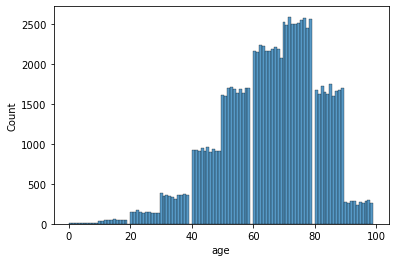

In [17]:
sns.histplot(x='age', data=df);

Let's now deal with the diagnosis code columns, since these are categorical variables that will need to be binned.

## Diagnosis Codes

In [18]:
df.diag_1.nunique()

713

There are over 700 unique values for diagnosis codes, which represent different ICD-9 codes. ICD-9 codes can be categorized into broader categories--we are going to recode the ICD-9 codes into these 12 broader categories.

In [21]:
# create a function for converting ICD codes

def diag_category(df, cols):
    for col in cols: 
        df.loc[(df[col].str.contains("V")) | (df[col].str.contains("E")), col] = -1
        df[col] = df[col].astype(np.float)
        
    for col in cols:
        df['diagnosis'] = np.nan
        df.loc[(df[col]>=390) & (df[col]<=459) | (df[col]==785), "diagnosis"] = "circulatory"
        df.loc[(df[col]>=460) & (df[col]<=519) | (df[col]==786), "diagnosis"] = "respiratory"
        df.loc[(df[col]>=520) & (df[col]<=579) | (df[col]==787), "diagnosis"] = "digestive"
        df.loc[(df[col]>=580) & (df[col]<=629) | (df[col]==788), "diagnosis"] = "genitourinary"
        df.loc[(df[col]>=240) & (df[col]<=279), "diagnosis"] = "endocrine"
        df.loc[(df[col]>=800) & (df[col]<=999), "diagnosis"] = "injury"
        df.loc[(df[col]>=710) & (df[col]<=739), "diagnosis"] = "musculoskeletal"
        df.loc[(df[col]>=140) & (df[col]<=239), "diagnosis"] = "neoplasms"
        df.loc[(df[col]>=280) & (df[col]<=289), "diagnosis"] = "blood"
        df.loc[(df[col]>=290) & (df[col]<=319), "diagnosis"] = "mental"
        df.loc[(df[col]>=320) & (df[col]<=389), "diagnosis"] = "nervous"
        
        df["diagnosis"] = df["diagnosis"].fillna("Other")
        df[col] = df["diagnosis"]
        df = df.drop("diagnosis", axis=1)
    return df

In [22]:
df = diag_category(df,["diag_1","diag_2","diag_3"])

In [23]:
df.diag_1.value_counts()

circulatory        29629
respiratory        13993
endocrine          10557
Other              10555
digestive           9187
injury              6703
genitourinary       4983
musculoskeletal     4739
neoplasms           3312
mental              2145
nervous             1170
blood               1079
Name: diag_1, dtype: int64

## Install ICD-9 and retrieve ICD Categories

In [24]:
# pip install icd9cms

In [25]:
# #install ICD-9 library that has the parent category information for each diagnosis code and import search method
# from icd9cms.icd9 import search
# search('001')

# # Codes can be searched for with or without the implied '.'  
# search('001.0') == search('0010')

In [26]:
# #write function for obtaining the parent category of each row's main ICD code
# def get_parent(x):
#     if search(x):
#         parent = search(x).parent
#         parent = str(parent).split(':')[1]
#     else:
#         parent = 'N/A'
#     return parent

In [27]:
# df['parent_diagnosis'] = df.diag_1.apply(lambda x: get_parent(x))

In [28]:
# df['parent_diagnosis'].nunique()

There are 114 different categories of parent diagnoses. Since this isn't a practical amount of columns to be added to our dataset after converting to dummy variables, let's only include the top diagnoses and bucket the rest into 'other'.

In [29]:
# df.groupby('parent_diagnosis').count()

We now have the diagnoses sorted into 114 categories. For categories with less than 1500 items, let's group all of these categories into an "other" category to simplify our model.

In [30]:
# df['diagnosis_count'] = df.groupby('parent_diagnosis')['parent_diagnosis'].transform('count')

In [31]:
# df.loc[df['diagnosis_count']<1500, ['parent_diagnosis']] = 'Other'

In [32]:
# df['parent_diagnosis'].nunique()

Now that we have categorized the data based on main diagnosis code, we can go ahead and drop the diagnosis code columns, as well as the diagnosis count column.

In [33]:
# df.drop(columns=['diag_1', 'diag_2','diag_3', 'diagnosis_count'], inplace=True)

## Drug Categories

Let's now revisit the columns in our dataset that provide the patient's drug information. In the vast majority of cases, the drug was provided to less than 1% of patients. It will be very difficult to determine any sort of relationship between these drugs and hospital readmits, since so few patients received the drug. Since we are already going to have a high number of categorical columns based on other factors, we are going to drop the columns where less than 1% of patients received a drug.

In [34]:
for col in df.columns:
    print(df[col].value_counts(normalize=True)[:5])
    print('--------------------------------------')

116046918    0.00001
278564922    0.00001
86284806     0.00001
404438606    0.00001
101771784    0.00001
Name: encounter_id, dtype: float64
--------------------------------------
88785891    0.000398
1660293     0.000235
88227540    0.000235
23199021    0.000235
84428613    0.000224
Name: patient_nbr, dtype: float64
--------------------------------------
Caucasian          0.765706
AfricanAmerican    0.192561
Hispanic           0.020234
Other              0.015125
Asian              0.006374
Name: race, dtype: float64
--------------------------------------
Female    0.538826
Male      0.461174
Name: gender, dtype: float64
--------------------------------------
72    0.026486
77    0.026262
79    0.026149
76    0.026088
70    0.025843
Name: age, dtype: float64
--------------------------------------
1    0.532146
3    0.185544
2    0.178915
6    0.052370
5    0.047536
Name: admission_type_id, dtype: float64
--------------------------------------
1     0.587535
3     0.138335
6     0.1287

In [35]:
df.drop(columns=['nateglinide', 'chlorpropamide','acetohexamide', 
                 'tolbutamide', 'acarbose', 'miglitol', 'troglitazone',
                'tolazamide', 'examide','citoglipton', 'glyburide-metformin',
                'glipizide-metformin','glimepiride-pioglitazone',
                'metformin-rosiglitazone', 'metformin-pioglitazone'], inplace=True)

In [36]:
df.head()

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,...,repaglinide,glimepiride,glipizide,glyburide,pioglitazone,rosiglitazone,insulin,change,diabetesMed,readmitted
1,149190,55629189,Caucasian,Female,11,1,1,7,3,59,...,No,No,No,No,No,No,Up,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,23,1,1,7,2,11,...,No,No,Steady,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,38,1,1,7,2,44,...,No,No,No,No,No,No,Up,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,44,1,1,7,1,51,...,No,No,Steady,No,No,No,Steady,Ch,Yes,NO
5,35754,82637451,Caucasian,Male,51,2,1,2,3,31,...,No,No,No,No,No,No,Steady,No,Yes,>30


Now that we've taken a first pass through the drug information, let's explore the remaining features we have and if any further changes need to be made.

In [37]:
df.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'diag_1', 'diag_2', 'diag_3', 'number_diagnoses',
       'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'glimepiride',
       'glipizide', 'glyburide', 'pioglitazone', 'rosiglitazone', 'insulin',
       'change', 'diabetesMed', 'readmitted'],
      dtype='object')

In [38]:
drugs = ['metformin', 'repaglinide', 'glimepiride', 'glipizide', 
         'glyburide', 'pioglitazone', 'rosiglitazone', 'insulin']

In [39]:
for col in df[drugs]:
    print(df[col].value_counts(normalize=True)[:5])
    print('--------------------------------------')

No        0.803727
Steady    0.180282
Up        0.010372
Down      0.005619
Name: metformin, dtype: float64
--------------------------------------
No        0.984467
Steady    0.013982
Up        0.001091
Down      0.000459
Name: repaglinide, dtype: float64
--------------------------------------
No        0.949139
Steady    0.045772
Up        0.003213
Down      0.001877
Name: glimepiride, dtype: float64
--------------------------------------
No        0.874730
Steady    0.112083
Up        0.007669
Down      0.005517
Name: glipizide, dtype: float64
--------------------------------------
No        0.895351
Steady    0.091095
Up        0.008067
Down      0.005487
Name: glyburide, dtype: float64
--------------------------------------
No        0.927620
Steady    0.068892
Up        0.002315
Down      0.001173
Name: pioglitazone, dtype: float64
--------------------------------------
No        0.937115
Steady    0.060254
Up        0.001775
Down      0.000857
Name: rosiglitazone, dtype: float64

When converting these drugs into categorical variables, keeping all of these categories would cause 32 new columns to be added to our dataframe. With the exception of insulin, the vast majority of patients are not prescribed these drugs. Instead of keeping 4 categories for each drug, let's recode these values into 0 if not prescribed the drug and 1 if a patient is prescribed the drug (whether steady, up or down). We will leave in the categories for insulin, since more than half of patients are prescribed insulin.

In [40]:
drugs.remove('insulin')
drug_dict = {'No': 0, 'Steady': 1, 'Up': 1, 'Down': 1}
for col in df[drugs]:
    df[col] = df[col].map(drug_dict)

df.head()

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,...,repaglinide,glimepiride,glipizide,glyburide,pioglitazone,rosiglitazone,insulin,change,diabetesMed,readmitted
1,149190,55629189,Caucasian,Female,11,1,1,7,3,59,...,0,0,0,0,0,0,Up,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,23,1,1,7,2,11,...,0,0,1,0,0,0,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,38,1,1,7,2,44,...,0,0,0,0,0,0,Up,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,44,1,1,7,1,51,...,0,0,1,0,0,0,Steady,Ch,Yes,NO
5,35754,82637451,Caucasian,Male,51,2,1,2,3,31,...,0,0,0,0,0,0,Steady,No,Yes,>30


We can also encode 'change' and 'diabetesMed' to be binary variables.

In [41]:
dict = {'No': 0, 'Ch': 1, 'Yes': 1}

df['change'] = df['change'].map(dict)
df['diabetesMed'] = df['diabetesMed'].map(dict)

In [42]:
df.head()

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,...,repaglinide,glimepiride,glipizide,glyburide,pioglitazone,rosiglitazone,insulin,change,diabetesMed,readmitted
1,149190,55629189,Caucasian,Female,11,1,1,7,3,59,...,0,0,0,0,0,0,Up,1,1,>30
2,64410,86047875,AfricanAmerican,Female,23,1,1,7,2,11,...,0,0,1,0,0,0,No,0,1,NO
3,500364,82442376,Caucasian,Male,38,1,1,7,2,44,...,0,0,0,0,0,0,Up,1,1,NO
4,16680,42519267,Caucasian,Male,44,1,1,7,1,51,...,0,0,1,0,0,0,Steady,1,1,NO
5,35754,82637451,Caucasian,Male,51,2,1,2,3,31,...,0,0,0,0,0,0,Steady,0,1,>30


## Admission and Discharge Type

The columns admission_type_id, discharge_disposition_id and admission_source_id are nominal values that stand for different classifications of admissions and discharges. Instead of leaving these values as numbers, since they are actually categorical, let's rename them to what each actually means. Note: we are going to use broader categories than provided to make our dataset easier to work with.

In [43]:
ID_cols = ['admission_type_id', 'discharge_disposition_id', 'admission_source_id']

admit_dict = {1:'Emergency', 2:'Emergency', 3:'Elective', 4:'Newborn', 5:'Unknown', 
              6:'Unknown', 7:'TraumaCenter', 8:'Unknown'} 

df['admission_type_id'] = df['admission_type_id'].map(admit_dict)

In [44]:
discharge_dict = {}

discharge_dict = dict.fromkeys([1,6,7,8,13], 'home')
discharge_dict.update(dict.fromkeys([2,3,4,5,10,14,15,16,17,22,23,24,30,27,28,29], 'transfer'))
discharge_dict.update(dict.fromkeys([9,12], 'not_discharged'))
discharge_dict.update(dict.fromkeys([11,19,20,21], 'death'))
discharge_dict.update(dict.fromkeys([18,25,26], 'unknown'))

discharge_dict

{1: 'home',
 6: 'home',
 7: 'home',
 8: 'home',
 13: 'home',
 2: 'transfer',
 3: 'transfer',
 4: 'transfer',
 5: 'transfer',
 10: 'transfer',
 14: 'transfer',
 15: 'transfer',
 16: 'transfer',
 17: 'transfer',
 22: 'transfer',
 23: 'transfer',
 24: 'transfer',
 30: 'transfer',
 27: 'transfer',
 28: 'transfer',
 29: 'transfer',
 9: 'not_discharged',
 12: 'not_discharged',
 11: 'death',
 19: 'death',
 20: 'death',
 21: 'death',
 18: 'unknown',
 25: 'unknown',
 26: 'unknown'}

In [45]:
df['discharge_disposition_id'] = df['discharge_disposition_id'].map(discharge_dict)

Admission Source ID is really just a more detailed categorization of the admission type. Since we already have the broad information, let's drop this column.

In [46]:
df.drop('admission_source_id', axis=1, inplace=True)

In [47]:
df.head()

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,time_in_hospital,num_lab_procedures,num_procedures,...,repaglinide,glimepiride,glipizide,glyburide,pioglitazone,rosiglitazone,insulin,change,diabetesMed,readmitted
1,149190,55629189,Caucasian,Female,11,Emergency,home,3,59,0,...,0,0,0,0,0,0,Up,1,1,>30
2,64410,86047875,AfricanAmerican,Female,23,Emergency,home,2,11,5,...,0,0,1,0,0,0,No,0,1,NO
3,500364,82442376,Caucasian,Male,38,Emergency,home,2,44,1,...,0,0,0,0,0,0,Up,1,1,NO
4,16680,42519267,Caucasian,Male,44,Emergency,home,1,51,0,...,0,0,1,0,0,0,Steady,1,1,NO
5,35754,82637451,Caucasian,Male,51,Emergency,home,3,31,6,...,0,0,0,0,0,0,Steady,0,1,>30


## Readmission Data

As we mentioned above, the data groups our readmits into two different categories: a readmit in less than 30 days and a readmit in more than 30 days. The timing of the readmission isn't incredibly important to our client; they are more concerned with stopping readmissions altogether. Since we are only interested in whether or not there is a readmission, we are going to recode our dependent variable to create a binary classification problem.

In [48]:
df['readmitted'] = df.readmitted.replace({"NO":0,
                         "<30":1, ">30":1})
df.head()

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,time_in_hospital,num_lab_procedures,num_procedures,...,repaglinide,glimepiride,glipizide,glyburide,pioglitazone,rosiglitazone,insulin,change,diabetesMed,readmitted
1,149190,55629189,Caucasian,Female,11,Emergency,home,3,59,0,...,0,0,0,0,0,0,Up,1,1,1
2,64410,86047875,AfricanAmerican,Female,23,Emergency,home,2,11,5,...,0,0,1,0,0,0,No,0,1,0
3,500364,82442376,Caucasian,Male,38,Emergency,home,2,44,1,...,0,0,0,0,0,0,Up,1,1,0
4,16680,42519267,Caucasian,Male,44,Emergency,home,1,51,0,...,0,0,1,0,0,0,Steady,1,1,0
5,35754,82637451,Caucasian,Male,51,Emergency,home,3,31,6,...,0,0,0,0,0,0,Steady,0,1,1


Let's quickly check for multicollinearity among features before continuing.

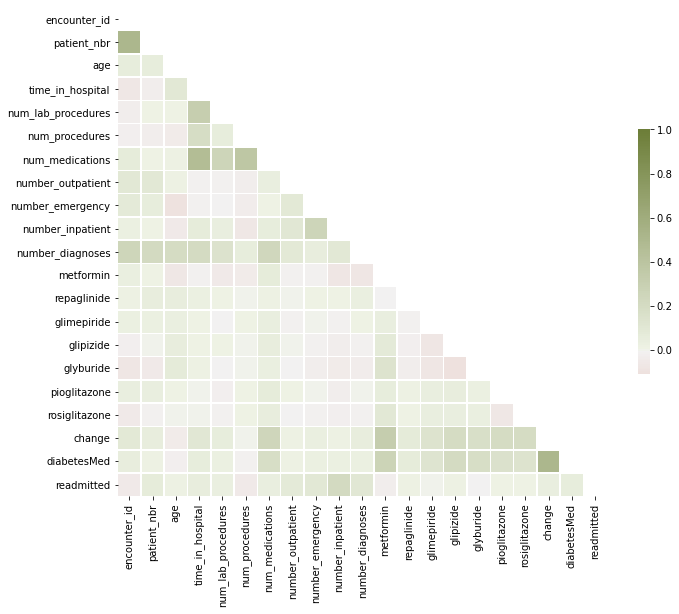

In [49]:
#Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(20, 100, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

In [50]:
df_pairs=df.corr().abs().stack().reset_index().sort_values(0, ascending=False)

# zip the variable name columns in a new column named "pairs"
df_pairs['pairs'] = list(zip(df_pairs.level_0, df_pairs.level_1))

# set index to pairs
df_pairs.set_index(['pairs'], inplace = True)

# drop level columns
df_pairs.drop(columns=['level_1', 'level_0'], inplace = True)

# rename correlation column as cc 
df_pairs.columns = ['cc']

# drop duplicates
df_pairs.drop_duplicates(inplace=True)

In [51]:
df_pairs[(df_pairs.cc>.75) & (df_pairs.cc <1)]

,cc
pairs,


Now that the initial data cleaning is complete, we can begin converting our categorical variables to dummy variables.

## Convert Categorical to Dummy Variables

In [52]:
# separate into continuous and categorical variables

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98052 entries, 1 to 101765
Data columns (total 31 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   encounter_id              98052 non-null  int64 
 1   patient_nbr               98052 non-null  int64 
 2   race                      98052 non-null  object
 3   gender                    98052 non-null  object
 4   age                       98052 non-null  int64 
 5   admission_type_id         98052 non-null  object
 6   discharge_disposition_id  98052 non-null  object
 7   time_in_hospital          98052 non-null  int64 
 8   num_lab_procedures        98052 non-null  int64 
 9   num_procedures            98052 non-null  int64 
 10  num_medications           98052 non-null  int64 
 11  number_outpatient         98052 non-null  int64 
 12  number_emergency          98052 non-null  int64 
 13  number_inpatient          98052 non-null  int64 
 14  diag_1               

In [53]:
not_cat = ['encounter_id', 'patient_nbr','time_in_hospital','num_lab_procedures',
         'num_procedures','num_medications','number_outpatient',
         'number_emergency','number_inpatient','number_diagnoses',
          'metformin', 'repaglinide', 'glimepiride', 'glipizide', 'glyburide',
           'pioglitazone', 'rosiglitazone', 'change', 'diabetesMed']

In [54]:
cats = []
for col in df.columns:
    if col not in not_cat:
        cats.append(col)
cats

['race',
 'gender',
 'age',
 'admission_type_id',
 'discharge_disposition_id',
 'diag_1',
 'diag_2',
 'diag_3',
 'max_glu_serum',
 'A1Cresult',
 'insulin',
 'readmitted']

In [55]:
cats.remove('readmitted')

In [56]:
df_cat = df.loc[:,cats]

In [57]:
df_cat = pd.get_dummies(df_cat, drop_first=True)

In [58]:
df_cat

,age,race_Asian,race_Caucasian,race_Hispanic,race_Other,gender_Male,admission_type_id_Emergency,admission_type_id_Newborn,admission_type_id_TraumaCenter,admission_type_id_Unknown,...,diag_3_respiratory,max_glu_serum_>300,max_glu_serum_None,max_glu_serum_Norm,A1Cresult_>8,A1Cresult_None,A1Cresult_Norm,insulin_No,insulin_Steady,insulin_Up
1,11,0,1,0,0,0,1,0,0,0,...,0,0,1,0,0,1,0,0,0,1
2,23,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,1,0,1,0,0
3,38,0,1,0,0,1,1,0,0,0,...,0,0,1,0,0,1,0,0,0,1
4,44,0,1,0,0,1,1,0,0,0,...,0,0,1,0,0,1,0,0,1,0
5,51,0,1,0,0,1,1,0,0,0,...,0,0,1,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,71,0,0,0,0,1,1,0,0,0,...,0,0,1,0,1,0,0,0,0,0
101762,86,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,1,0,0,1,0
101763,79,0,1,0,0,1,1,0,0,0,...,0,0,1,0,0,1,0,0,0,0
101764,88,0,1,0,0,0,1,0,0,0,...,0,0,1,0,0,1,0,0,0,1


In [59]:
df_cat.columns

Index(['age', 'race_Asian', 'race_Caucasian', 'race_Hispanic', 'race_Other',
       'gender_Male', 'admission_type_id_Emergency',
       'admission_type_id_Newborn', 'admission_type_id_TraumaCenter',
       'admission_type_id_Unknown', 'discharge_disposition_id_home',
       'discharge_disposition_id_not_discharged',
       'discharge_disposition_id_transfer', 'discharge_disposition_id_unknown',
       'diag_1_blood', 'diag_1_circulatory', 'diag_1_digestive',
       'diag_1_endocrine', 'diag_1_genitourinary', 'diag_1_injury',
       'diag_1_mental', 'diag_1_musculoskeletal', 'diag_1_neoplasms',
       'diag_1_nervous', 'diag_1_respiratory', 'diag_2_blood',
       'diag_2_circulatory', 'diag_2_digestive', 'diag_2_endocrine',
       'diag_2_genitourinary', 'diag_2_injury', 'diag_2_mental',
       'diag_2_musculoskeletal', 'diag_2_neoplasms', 'diag_2_nervous',
       'diag_2_respiratory', 'diag_3_blood', 'diag_3_circulatory',
       'diag_3_digestive', 'diag_3_endocrine', 'diag_3_genitour

Let's fix the names of the columns to not have spaces, since this could be problematic for our modeling down the line.

In [60]:
dictionary = {' ':'_', '[':'', ')':'','>':'_'}
df_cat.columns = [c.replace(' ','_') for c in df_cat.columns]
df_cat.columns

Index(['age', 'race_Asian', 'race_Caucasian', 'race_Hispanic', 'race_Other',
       'gender_Male', 'admission_type_id_Emergency',
       'admission_type_id_Newborn', 'admission_type_id_TraumaCenter',
       'admission_type_id_Unknown', 'discharge_disposition_id_home',
       'discharge_disposition_id_not_discharged',
       'discharge_disposition_id_transfer', 'discharge_disposition_id_unknown',
       'diag_1_blood', 'diag_1_circulatory', 'diag_1_digestive',
       'diag_1_endocrine', 'diag_1_genitourinary', 'diag_1_injury',
       'diag_1_mental', 'diag_1_musculoskeletal', 'diag_1_neoplasms',
       'diag_1_nervous', 'diag_1_respiratory', 'diag_2_blood',
       'diag_2_circulatory', 'diag_2_digestive', 'diag_2_endocrine',
       'diag_2_genitourinary', 'diag_2_injury', 'diag_2_mental',
       'diag_2_musculoskeletal', 'diag_2_neoplasms', 'diag_2_nervous',
       'diag_2_respiratory', 'diag_3_blood', 'diag_3_circulatory',
       'diag_3_digestive', 'diag_3_endocrine', 'diag_3_genitour

In [61]:
df_clean = pd.concat([df, df_cat], axis=1)
df_clean.drop(columns=cats, inplace=True)

In [62]:
df_clean.head()

,encounter_id,patient_nbr,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,...,diag_3_respiratory,max_glu_serum_>300,max_glu_serum_None,max_glu_serum_Norm,A1Cresult_>8,A1Cresult_None,A1Cresult_Norm,insulin_No,insulin_Steady,insulin_Up
1,149190,55629189,3,59,0,18,0,0,0,9,...,0,0,1,0,0,1,0,0,0,1
2,64410,86047875,2,11,5,13,2,0,1,6,...,0,0,1,0,0,1,0,1,0,0
3,500364,82442376,2,44,1,16,0,0,0,7,...,0,0,1,0,0,1,0,0,0,1
4,16680,42519267,1,51,0,8,0,0,0,5,...,0,0,1,0,0,1,0,0,1,0
5,35754,82637451,3,31,6,16,0,0,0,9,...,0,0,1,0,0,1,0,0,1,0


In [63]:
df_clean.columns

Index(['encounter_id', 'patient_nbr', 'time_in_hospital', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'number_diagnoses', 'metformin',
       'repaglinide', 'glimepiride', 'glipizide', 'glyburide', 'pioglitazone',
       'rosiglitazone', 'change', 'diabetesMed', 'readmitted', 'race_Asian',
       'race_Caucasian', 'race_Hispanic', 'race_Other', 'gender_Male',
       'admission_type_id_Emergency', 'admission_type_id_Newborn',
       'admission_type_id_TraumaCenter', 'admission_type_id_Unknown',
       'discharge_disposition_id_home',
       'discharge_disposition_id_not_discharged',
       'discharge_disposition_id_transfer', 'discharge_disposition_id_unknown',
       'diag_1_blood', 'diag_1_circulatory', 'diag_1_digestive',
       'diag_1_endocrine', 'diag_1_genitourinary', 'diag_1_injury',
       'diag_1_mental', 'diag_1_musculoskeletal', 'diag_1_neoplasms',
       'diag_1_nervous', 'diag_1_respi

# Explore

In this project, readmitted is going to be our target variable, or y. Let's plot this variable to get a sense for its distribution.

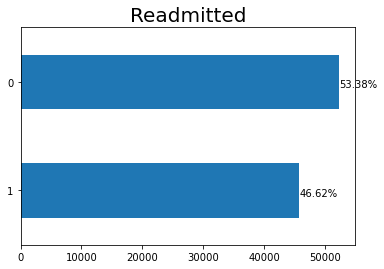

In [64]:

ax = df_clean['readmitted'].value_counts().sort_values().plot(kind="barh")
totals= []
for i in ax.patches:
    totals.append(i.get_width())
total = sum(totals)
for i in ax.patches:
     ax.text(i.get_width()+.3, i.get_y()+.20, 
     str(round((i.get_width()/total)*100, 2))+'%', 
     fontsize=10, color='black')
plt.title('Readmitted', fontsize=20)
plt.show()

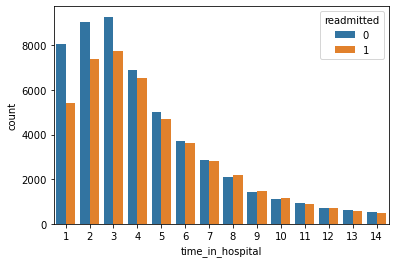

In [65]:
sns.countplot(x = 'time_in_hospital', data = df_clean, hue='readmitted');

It appears the more days a patient stays in the hospital, the more likely they are to be readmitted, especially after 30 days.

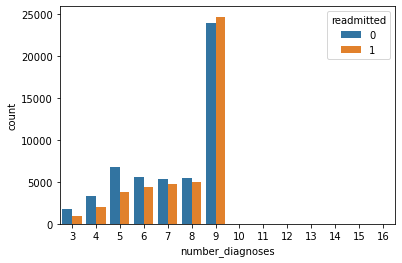

In [66]:
sns.countplot(x = 'number_diagnoses', 
              data = df_clean, hue='readmitted');

It also appears that as our number of diagnoses increases, so does the number of readmissions. Let's look closer at the trend under 10 diagnoses.

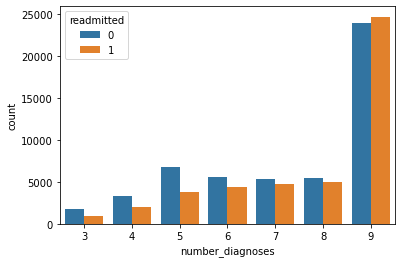

In [67]:
sns.countplot(x = 'number_diagnoses', 
              data = df_clean[df_clean['number_diagnoses']<10], hue='readmitted');

There is a clear trend that as the number of diagnoses increases, the percentage of patients being readmitted also increases.

Text(0.5, 1.0, 'Time in Hospital VS. Readmission')

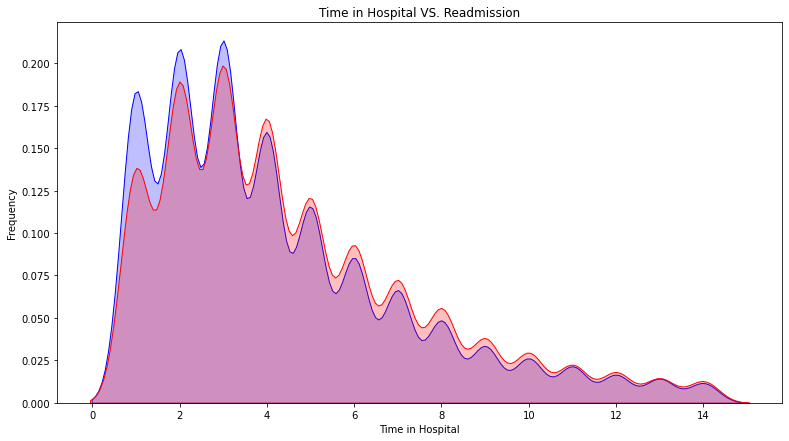

In [68]:
fig = plt.figure(figsize=(13,7),)
ax=sns.kdeplot(df.loc[(df['readmitted'] == 0),'time_in_hospital'] , color='b',shade=True,label='Not Readmitted')
ax=sns.kdeplot(df.loc[(df['readmitted'] == 1),'time_in_hospital'] , color='r',shade=True, label='Readmitted')
ax.set(xlabel='Time in Hospital', ylabel='Frequency')
plt.title('Time in Hospital VS. Readmission')

Text(0.5, 1.0, 'Number of medication used VS. Readmission')

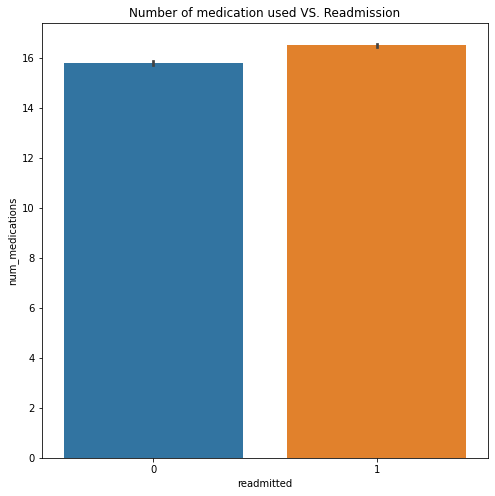

In [69]:
fig = plt.figure(figsize=(8,8))
sns.barplot(x = df['readmitted'], y = df['num_medications']).set_title("Number of medication used VS. Readmission")

C:\Users\saman\anaconda3\envs\learn-env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Diabetes Medication prescribed VS Readmission')

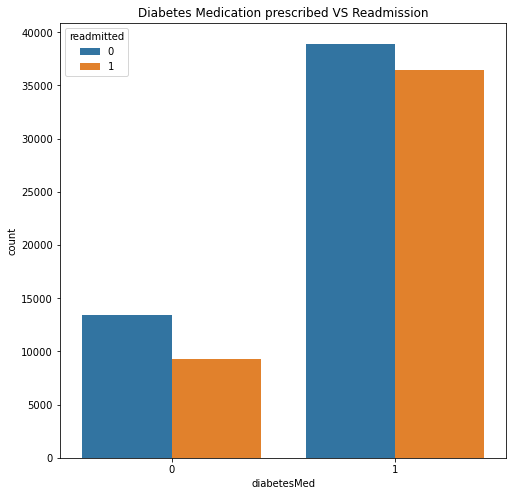

In [70]:
fig = plt.figure(figsize=(8,8))
sns.countplot(df['diabetesMed'], hue = df['readmitted']).set_title('Diabetes Medication prescribed VS Readmission')

Text(0.5, 1.0, 'Number of lab procedure VS. Readmission')

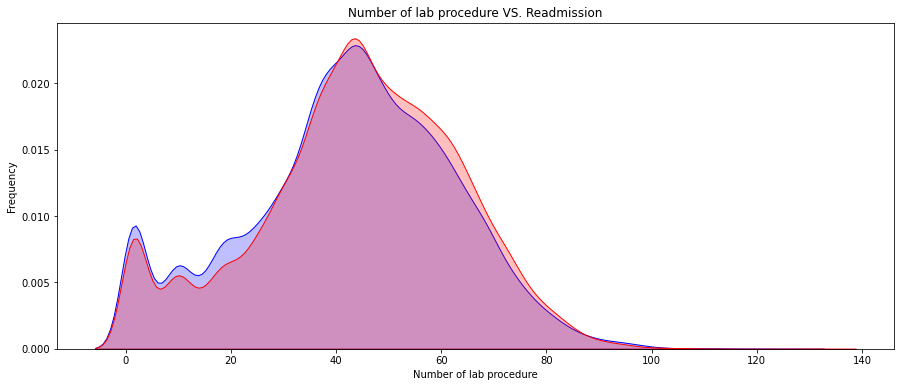

In [71]:
fig = plt.figure(figsize=(15,6),)
ax=sns.kdeplot(df.loc[(df['readmitted'] == 0),'num_lab_procedures'] , color='b',shade=True,label='Not readmitted')
ax=sns.kdeplot(df.loc[(df['readmitted'] == 1),'num_lab_procedures'] , color='r',shade=True, label='readmitted')
ax.set(xlabel='Number of lab procedure', ylabel='Frequency')
plt.title('Number of lab procedure VS. Readmission')

In [72]:
# fig, axes = plt.subplots(nrows=6, ncols=4, figsize=(16,15), sharey=True)

# for ax, column in zip(axes.flatten(), df_clean.columns):
#     ax.scatter(df_clean[column], df_clean['readmitted'], label=column, alpha=.1, color='coral')
#     ax.set_title(f'readmission v. {column}')
#     ax.set_xlabel(column)
#     ax.set_ylabel('Readmits')

# fig.tight_layout()

## Export Clean Data

In [73]:
df_clean.to_csv('data/diabetes_data_clean.csv')